# Table of Contents
 <p><div class="lev1"><a href="#Derive-scaling"><span class="toc-item-num">1&nbsp;&nbsp;</span>Derive scaling</a></div><div class="lev1"><a href="#Improve-OGS09-scaling"><span class="toc-item-num">2&nbsp;&nbsp;</span>Improve OGS09 scaling</a></div><div class="lev2"><a href="#Experiment-with-vertical-integrals"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Experiment with vertical integrals</a></div>

In [1]:
%load_ext autoreload
%matplotlib inline

In [279]:
%autoreload 2

import numpy as np
import dask.array as da
import matplotlib.pyplot as plt
import datetime as dt
import sys,os,glob
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LogNorm
from scipy.stats import gaussian_kde

## Add own library to path
workdir = os.getcwd()
thismodule = sys.modules[__name__]
moduledir = os.path.join(os.path.dirname(workdir),'functions')
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])
## Load own libraries
from thermoConstants import *
from thermoFunctions import *
from environmentAndDirectories import *
from importingData import *
from scalingApproximations import *
from slicingAndSubsetting import *
from statisticalDistributions import *

Own modules available: ['CAMsettings', 'daskOptions', 'environmentAndDirectories', 'importingData', 'outputResults', 'physicalConstants', 'plot1DInvLog', 'plot2D', 'plotMaps', 'scalingApproximations', 'slicingAndSubsetting', 'statisticalDistributions', 'thermoConstants', 'thermoFunctions']


In [86]:
compset = 'FSPCAMm_AMIP'
experiment = 'piControl'
subset = 'tropics'
time_stride = '3hr'
resolution = '1dx'
daskarray = False
tracktime = True
dates = ('185005010100','185005020000')

historyFilesSettings = getCAMHistoryFilesSettings()
handle = 'h0'
inputdir, inputdir_processed_day, inputdir_processed_1hr, inputdir_results, inputdir_fx = \
    getInputDirectories(compset,experiment)

    
q_id = 'Q'
spechum = getValues(q_id,compset,subset,experiment,time_stride,resolution,daskarray=daskarray,dates=dates,handle=handle)
omega_id = 'OMEGA'
omega = getValues(omega_id,compset,subset,experiment,time_stride,resolution,daskarray=daskarray,dates=dates,handle=handle)
pr_id = 'PRECT'
pr = getValues(pr_id,compset,subset,experiment,time_stride,resolution,daskarray=daskarray,dates=dates,handle=handle)
pr *= rho_l    # convert from m/s to kg/m2/s
ts_id = 'TS'
ts = getValues(ts_id,compset,subset,experiment,time_stride,resolution,daskarray=daskarray,dates=dates,handle=handle)
relhum_id = 'RELHUM'
relhum = getValues(relhum_id,compset,subset,experiment,time_stride,resolution,daskarray=daskarray,dates=dates,handle=handle)
ta_id = 'T'
ta = getValues(ta_id,compset,subset,experiment,time_stride,resolution,daskarray=daskarray,dates=dates,handle=handle)

Importing Q from 24 history files between 1850-05-01-03600 and 1850-05-02-00000
Importing OMEGA from 24 history files between 1850-05-01-03600 and 1850-05-02-00000
Importing PRECT from 24 history files between 1850-05-01-03600 and 1850-05-02-00000
Importing TS from 24 history files between 1850-05-01-03600 and 1850-05-02-00000
Importing RELHUM from 24 history files between 1850-05-01-03600 and 1850-05-02-00000
Importing T from 24 history files between 1850-05-01-03600 and 1850-05-02-00000


In [87]:
## Get longitude, latitude and landmask

fh = Dataset(os.path.join(inputdir_fx,'landmask_fx_CESM111-SPCAM20_allExperiments_r0i0p0.nc'))
lon1D = fh.variables['lon'][:]
lat1D = fh.variables['lat'][:]
lon2D, lat2D = np.meshgrid(lon1D,lat1D)

print("Loading lontigude, latitude and landmask")

landmask = fh.variables['landmask']


Loading lontigude, latitude and landmask


In [88]:
input_lev_file = os.path.join(inputdir_fx,'lev_fx_CESM111-SPCAM20_allExperiments_r0i0p0.nc')
computeP = getPressureCoordinateFunction(input_lev_file)

In [89]:
ps_varid = 'PS'
ps = getValues(ps_varid,compset,subset,experiment,time_stride,resolution,daskarray=daskarray,dates=dates,handle=handle)
pres = computeP(ps)
cn = getArrayType(pres)

Importing PS from 24 history files between 1850-05-01-03600 and 1850-05-02-00000


# Derive scaling

In [301]:
%%time
print("Compute ranks and ranks locations")

n_pts = pr.size
Q_IL = getInvLogRanks(n_pts,n_pts_per_bin=1,fill_last_decade=True)
i_Q = indexOfRank(99.9,Q_IL)
iQ_slice = slice(i_Q-5,i_Q+5)
ranks, centers, bins = computePercentilesAndBinsFromRanks(pr.flatten(),Q_IL)
iQ_min = 8
iQ_max = min(len(Q_IL),41)
# iQ_max = min(len(Q_IL),iQ_slice.stop)

# Define reference percentiles and compute percentiles
targetranks = Q_IL[iQ_min:iQ_max]
ranks_ref = Q_IL[:iQ_max]
percentiles = adjustRanks(centers,ranks,ranks_ref)

# Suffix to save figures and results
output_suffix = 'Q%d-Q%d_%s'%(iQ_min,iQ_max,'-'.join(dates))

rank_locations= {}
for rank in ranks_ref:
    rank_id  = "%2.4f"%rank
    print(rank_id,end=' ')
    rank_locations[rank_id] = getRankLocations(rank,pr,ranks,bins,rank_locations)
print()

Compute ranks and ranks locations
0.0000 20.5672 36.9043 49.8813 60.1893 68.3772 74.8811 80.0474 84.1511 87.4107 90.0000 92.0567 93.6904 94.9881 96.0189 96.8377 97.4881 98.0047 98.4151 98.7411 99.0000 99.2057 99.3690 99.4988 99.6019 99.6838 99.7488 99.8005 99.8415 99.8741 99.9000 99.9206 99.9369 99.9499 99.9602 99.9684 99.9749 99.9800 99.9842 99.9874 99.9900 
CPU times: user 10.5 ms, sys: 2.38 ms, total: 12.8 ms
Wall time: 14.1 ms


Try OGS09 scaling at 99.9th percentile
2.81663010808
check crop profiles


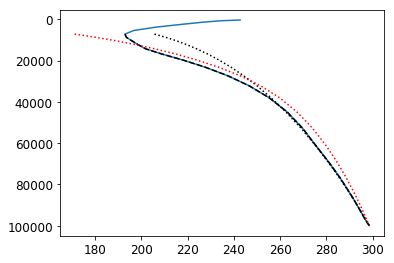

In [91]:
print("Try OGS09 scaling at 99.9th percentile")
ta_prQ999 = meanXProfileAtYRank(99.9,ta,pr,ranks_ref,rank_locations=rank_locations)
pres_prQ999 = meanXProfileAtYRank(99.9,pres,pr,ranks_ref,rank_locations=rank_locations)
omega_prQ999 = meanXProfileAtYRank(99.9,omega,pr,ranks_ref,rank_locations=rank_locations)
spechum_prQ999 = meanXProfileAtYRank(99.9,spechum,pr,ranks_ref,rank_locations=rank_locations)
relhum_prQ999 = meanXProfileAtYRank(99.9,relhum,pr,ranks_ref,rank_locations=rank_locations)
ts_prQ999 = meanXAtYRank(99.9,ts,pr,ranks_ref,rank_locations=rank_locations)
ps_prQ999 = meanXAtYRank(99.9,ps,pr,ranks_ref,rank_locations=rank_locations)

pres_prQ999_c, ta_prQ999_c, omega_prQ999_c, spechum_prQ999_c = \
cropProfiles(pres_prQ999,ta_prQ999,[omega_prQ999,spechum_prQ999])

t_ref = ta_prQ999_c[-1]
p_ref = pres_prQ999_c[-1]
# t_ref = ts_prQ999
# p_ref = ps_prQ999

qvstar_prQ999_c = saturationSpecificHumidity(ta_prQ999_c,pres_prQ999_c)
alpha = parameterMoistAdiabat(pres_prQ999_c,p_ref,t_ref,qvstar_prQ999_c)
print(alpha)

tadiab_approx_prQ999_c = moistAdiabatParametric(pres_prQ999_c,p_ref,t_ref,alpha)
tadiab_simple_prQ999_c = moistAdiabatSimple(t_ref,pres_prQ999_c,spechum_prQ999_c,reverse=True)

print("check crop profiles")
fig, ax = plt.subplots()
plt.plot(ta_prQ999,pres_prQ999)
plt.plot(ta_prQ999_c,pres_prQ999_c,'k--')
plt.plot(tadiab_approx_prQ999_c,pres_prQ999_c,'k:')
plt.plot(tadiab_simple_prQ999_c,pres_prQ999_c,'r:')
ax.invert_yaxis()

0.000909374111237
0.000909374111237
0.000970601886278


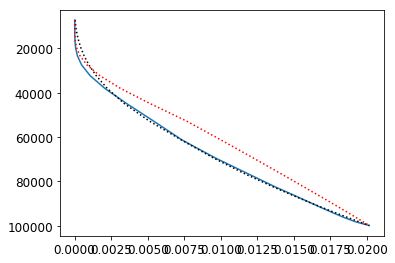

In [92]:
qvstar_prQ999_c = saturationSpecificHumidity(ta_prQ999_c,pres_prQ999_c)
qvstar_ad_approx_prQ999_c = saturationSpecificHumidity(tadiab_approx_prQ999_c,pres_prQ999_c)
qvstar_ad_simple_prQ999_c = saturationSpecificHumidity(tadiab_simple_prQ999_c,pres_prQ999_c)
dqvstar_prQ999_c = cn.diff(qvstar_prQ999_c)
dqvstar_ad_approx_prQ999_c = cn.diff(qvstar_ad_approx_prQ999_c)
dqvstar_ad_simple_prQ999_c = cn.diff(qvstar_ad_simple_prQ999_c)
dqvstar_dp_prQ999_c = cn.diff(qvstar_prQ999_c)/cn.diff(pres_prQ999_c)
print(-verticalPressureIntegral(pres_prQ999_c,values=omega_prQ999_c,dvdp=dqvstar_dp_prQ999_c))
print(scalingOGS09(omega_prQ999,ta_prQ999,pres_prQ999,levdim=0))
print(percentiles[i_Q])
fig, ax = plt.subplots()
plt.plot(qvstar_prQ999_c,pres_prQ999_c)
plt.plot(qvstar_ad_approx_prQ999_c,pres_prQ999_c,'k:')
plt.plot(qvstar_ad_simple_prQ999_c,pres_prQ999_c,'r:')
ax.invert_yaxis()

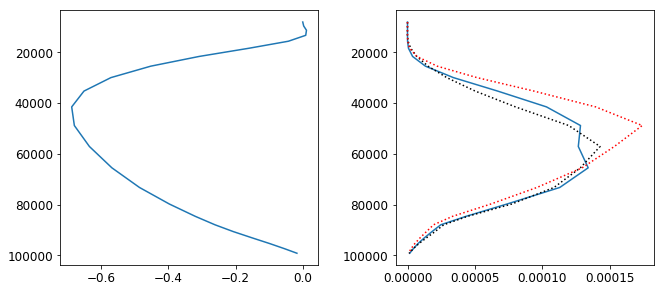

In [93]:
omega_prQ999_c_mids = cn.convolve(omega_prQ999_c,(0.5,0.5),mode='valid')
pres_prQ999_c_mids = cn.convolve(pres_prQ999_c,(0.5,0.5),mode='valid')
cond_prQ999_c = -omega_prQ999_c_mids*dqvstar_prQ999_c/gg
cond_ad_approx_prQ999_c = -omega_prQ999_c_mids*dqvstar_ad_approx_prQ999_c/gg
cond_ad_simple_prQ999_c = -omega_prQ999_c_mids*dqvstar_ad_simple_prQ999_c/gg

fig, ax = plt.subplots(ncols=2,figsize=(11,4.5))
ax[0].plot(omega_prQ999_c_mids,pres_prQ999_c_mids)
ax[0].invert_yaxis()
ax[1].plot(cond_prQ999_c,pres_prQ999_c_mids)
ax[1].plot(cond_ad_approx_prQ999_c,pres_prQ999_c_mids,'k:')
ax[1].plot(cond_ad_simple_prQ999_c,pres_prQ999_c_mids,'r:')
ax[1].invert_yaxis()

In [94]:
print("pr estimate ; efficiency factor")
print(cn.nansum(cond_prQ999_c),percentiles[i_Q]/cn.nansum(cond_prQ999_c))
print(cn.nansum(cond_ad_approx_prQ999_c),percentiles[i_Q]/cn.nansum(cond_ad_approx_prQ999_c))
print(cn.nansum(cond_ad_simple_prQ999_c),percentiles[i_Q]/cn.nansum(cond_ad_simple_prQ999_c))

pr estimate ; efficiency factor
0.000909374114526 1.06732957402
0.000879886246213 1.10309928182
0.001014538748 0.95669277116


# Improve OGS09 scaling

In [289]:
iQ_ref

range(25, 35)

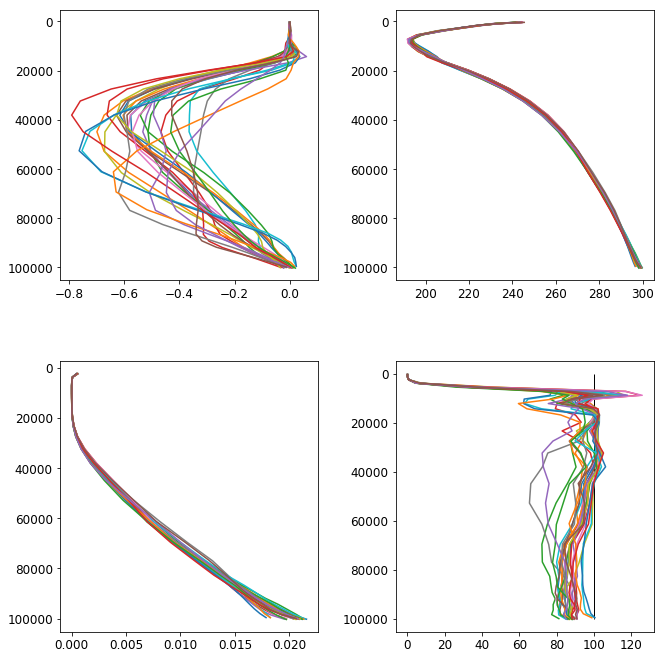

In [295]:
## EXPLORE PROFILES
iQ_ref = range(100)[iQ_slice]

varnames_for_scRH = ('omega','ta','pres','relhum','pr')

ranks_ref = ["%2.4f"%(ranks[iQ-1]) for iQ in iQ_ref]
# Initialize list for each variable
for varname in varnames_for_scRH:
    setattr(thismodule,"%s_ref_list"%varname,[])
# fill list with sample variables at each percentile
for rank in ranks_ref:
    stencil_Q = rank_locations[rank]
    for varname in varnames_for_scRH:
        var = getattr(thismodule,varname)
        var_list = getattr(thismodule,"%s_ref_list"%varname)
        var_list.append(sampleFlattened(var,stencil_Q))
# concat arrays from list
for varname in varnames_for_scRH:
    var_list = getattr(thismodule,"%s_ref_list"%varname)
    setattr(thismodule,"%s_ref"%varname,cn.hstack(var_list))

qvstar_ref = saturationSpecificHumidity(ta_ref,pres_ref)
    
# omega_all_prQ = sampleFlattened(omega,stencil_Q)
# ta_all_prQ = sampleFlattened(ta,stencil_Q)
# pres_all_prQ = sampleFlattened(pres,stencil_Q)
# relhum_all_prQ = sampleFlattened(relhum,stencil_Q)
# # spechum_all_prQ = sampleFlattened(spechum,stencil_Q)
# qvstar_all_prQ = saturationSpecificHumidity(ta_all_prQ,pres_all_prQ)

fig, ax = plt.subplots(ncols=2,nrows=2,figsize=(11,11))
for i in range(omega_all_prQ.shape[1]):
#     ax[0][0].plot(omega_all_prQ[:,i],pres_all_prQ[:,i])
#     ax[1][0].plot(qvstar_all_prQ[3:,i],pres_all_prQ[3:,i])
#     ax[0][1].plot(ta_all_prQ[:,i],pres_all_prQ[:,i])
#     ax[1][1].plot(relhum_all_prQ[:,i],pres_all_prQ[:,i])
    ax[0][0].plot(omega_ref[:,i],pres_ref[:,i])
    ax[1][0].plot(qvstar_ref[3:,i],pres_ref[3:,i])
    ax[0][1].plot(ta_ref[:,i],pres_ref[:,i])
    ax[1][1].plot(relhum_ref[:,i],pres_ref[:,i])
ax[1][1].vlines(100,0,100000,lw=1)
ax[0][0].invert_yaxis()
ax[1][0].invert_yaxis()
ax[0][1].invert_yaxis()
ax[1][1].invert_yaxis()
# print(scalingOGS09(omega_all_prQ,ta_all_prQ,pres_all_prQ,efficiency=eps_OGS09,levdim=0))

Extended scaling:

$$ P_{RH} = \frac{1}{2f-1}\left(-\int_{BL}^{trop} \omega \left.\frac{\partial q_v^\star}{\partial p}\right|_{\theta^\star} \frac{dp}{g} + \epsilon\int_{BL}^{trop} \omega (1-RH) q_v^\star \frac{dp}{\rho g^2}\right) $$

In [296]:
print("compute condensation rate")

levdim = 0
entrainment = 0.00001

pr_scRH = scalingRH(omega_all_prQ,ta_all_prQ,pres_all_prQ,relhum_all_prQ,spechum_all_prQ,entrainment=entrainment,levdim=levdim)

compute condensation rate


In [297]:
def func(x,a,b):
    s = []
    for i in range(4):
        s.append(slice(i*nlev,(i+1)*nlev))
    return scalingRH(x[s[0]],x[s[1]],x[s[2]],x[s[3]],fracarea_boost=a,entrainment=b,levdim=0)

In [298]:
from scipy.optimize import curve_fit

levdim = 0
nlev = omega_all_prQ.shape[0]
ndata = omega_all_prQ.shape[1]
xdata = np.vstack([omega_ref,ta_ref,pres_ref,relhum_ref])
ydata = pr_ref

p,c = curve_fit(func,xdata,ydata)
print("parameters:",p)
print("covariance matrix:",c)
print("normalized variances:",c[0][0]/p[0]**2,c[1][1]/p[1]**2)
print("normalized covariance:",c[0][1]/p[0]/p[1])

parameters: [  1.01337380e+00   8.27304180e-05]
covariance matrix: [[  6.80935439e-04   1.41774408e-06]
 [  1.41774408e-06   3.70321017e-09]]
normalized variances: 0.000663081014065 0.541063108209
normalized covariance: 0.0169107531961


In [318]:
print("compute extended scaling approximation")

p,c = computeParametersScalingRH(omega,ta,pres,relhum,pr,ranks_ref=ranks_ref[iQ_slice],
    temp_type='profile',rank_locations=rank_locations)

print("parameters:",p)
print("covariance matrix:",c)
print("normalized variances:",c[0][0]/p[0]**2,c[1][1]/p[1]**2)
print("normalized covariance:",c[0][1]/p[0]/p[1])

compute extended scaling approximation
parameters: [  1.01337380e+00   8.27304180e-05]
covariance matrix: [[  6.80935439e-04   1.41774408e-06]
 [  1.41774408e-06   3.70321017e-09]]
normalized variances: 0.000663081014065 0.541063108209
normalized covariance: 0.0169107531961


## Experiment with vertical integrals 

In [16]:
levdim = 1 
omega_pos = omega.copy()
omega_pos[omega > 0] = 0
qvstar = saturationSpecificHumidity(ta,pres)
dqvstar = cn.diff(qvstar,axis=levdim)
dq = cn.diff(spechum,axis=levdim)
dp = cn.diff(pres,axis=levdim) 
dq_dp = dq/dp
dqvstar_dp = dqvstar/dp

In [17]:
pr_est = -verticalPressureIntegral(pres,values=[omega],dvdp=dqvstar_dp,levdim=levdim)
pr_est_pos_omega = -verticalPressureIntegral(pres,values=[omega_pos],dvdp=dqvstar_dp,levdim=levdim)
detrained_est = verticalPressureIntegral(pres,values=[omega,1-relhum,qvstar],levdim=levdim)/gg
detrained_est_pos_omega = verticalPressureIntegral(pres,values=[omega,1-relhum,qvstar],levdim=levdim)/gg

In [20]:
pr_est.max(), pr.max()

(0.0014094984235247369, 0.0013875059)

In [21]:
print(np.isnan(pr).size,np.isnan(pr_est).size)

4608 4608


In [22]:
# Compute regression lines

x,y = pr_est.reshape(1,-1),pr.reshape(1,-1)

In [23]:
from scipy.stats import linregress

above = pr > 5e-8
# x,y = pr_est.reshape(1,-1),pr.reshape(1,-1)
x,y = pr_est[above],pr[above]
slope, intercept, r_value, p_value, std_err = linregress(x, y)
print(slope, intercept, r_value, p_value, std_err)

0.610167354652 3.17906027606e-05 0.841768727742 0.0 0.00667273380952


ValueError: Invalid RGBA argument: 124319276.64956979

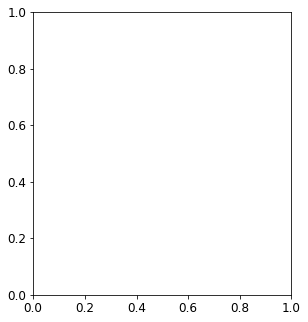

In [24]:
fig = plt.figure(figsize=(11,5))

ax = fig.add_subplot(121)

x_lims = (-1e-4,1e-4)
x_vals = np.linspace(x_lims[0],x_lims[1],100)

x,y = pr_est[above],pr[above]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

plt.scatter(pr_est,pr,c=z,s=100,edgecolor='')
plt.plot(x_vals,(slope*x_vals+intercept))
plt.xlim((-1e-4,1e-4))
plt.ylim((-1e-7,1e-6))


ax = fig.add_subplot(122)

plt.scatter(pr_est_pos_omega,pr)
plt.ylim((-1e-7,1e-6))
plt.xlim((-1e-4,1e-4))

(-0.0002, 0.0002)

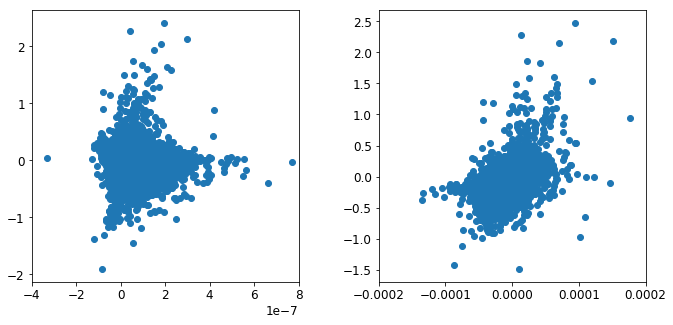

In [80]:
fig = plt.figure(figsize=(11,5))

ax = fig.add_subplot(121)

plt.scatter(pr-slope*pr_est,detrained_est)
plt.xlim((-4e-7,8e-7))
# plt.ylim((-1e-4,1e-4))

ax = fig.add_subplot(122)

plt.scatter(pr-pr_est_pos_omega,detrained_est_pos_omega)
plt.xlim((-2e-4,2e-4))
# plt.ylim((-1e-4,1e-4))